In [1]:
import pickle
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import imageio
import matplotlib.pyplot as plt

In [2]:
anno_files = [f for f in Path("./outputs").glob("*.pkl")]
frame_folders = [f for f in Path("./frames").glob("*") if f.is_dir()]
output_folder = Path("./outputs")

In [3]:
vid = "120201"
output_folder = output_folder/vid
output_folder.mkdir(exist_ok=True)

In [4]:
def get_anno_by_vid(vid):
    for file in anno_files:
        if vid in str(file):
            with open(file,'rb') as f:
                return pickle.load(f)
def get_frames_by_vid(vid):
    for file in frame_folders:
        if vid in str(file):
            return list(file.glob("*.png"))

In [6]:
anno = get_anno_by_vid(vid)
frames = get_frames_by_vid(vid)

In [7]:
assert len(anno.keys()) == len(frames)

In [34]:
# conf_list = []
# for frame in frames:
#     #image = cv2.imread(str(frame))
#     key = frame.name
#     det = anno[key]
#     if len(det.confidence)>0:
#         conf_list.append(max(det.confidence))

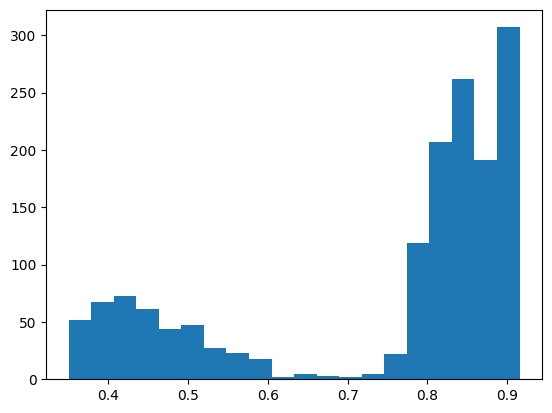

In [35]:
# import matplotlib.pyplot as plt
# counts, bins, _ = plt.hist(conf_list, bins=20)

In [39]:
def xyxy2center(xyxy):
    x0,y0,x1,y1 = xyxy
    xcenter = int((x0+x1)/2)
    ycenter = int((y0+y1)/2)
    return xcenter,ycenter
center_dict={}
for frame in tqdm(frames):
    image = cv2.imread(str(frame))
    key = frame.name
    detections =anno[key]
    if len(detections.confidence) ==0: continue
    anno_id = np.argmax(detections.confidence)
    conf = detections.confidence[anno_id]
    if conf<=0.75: continue
    xyxy = detections.xyxy[anno_id]
    mask = detections.mask[anno_id]
    xc,yc = xyxy2center(xyxy)
    center_dict[key] = [xc,yc]
    crop_img = image[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
    mask = np.stack((mask,)*3, axis=-1)
    mask_img = image*mask
    mask_img = mask_img[int(xyxy[1]):int(xyxy[3]),int(xyxy[0]):int(xyxy[2])]
    cv2.imwrite(str(output_folder/f"{key}_mask.png"),mask_img)

  0%|          | 0/1557 [00:00<?, ?it/s]

In [47]:
image = cv2.imread(str(frames[0]))
print(image.shape)
bk = np.zeros_like(image)
bk[bk==0] = 255

(1024, 1024, 3)


In [65]:
img_list = []
center_x = []
center_y = []
for frame in tqdm(frames):
    key = frame.name
    img = bk.copy()
    img = cv2.putText(img,frame.stem,(10,50),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,0),2,2)
    if key in center_dict:
        img = cv2.circle(img, center_dict[key], radius=5, color=(0, 0, 255), thickness=-1)
        center_x.append(center_dict[key][0])
        center_y.append(center_dict[key][1])
    img_list.append(img)
imageio.mimsave(str(output_folder/"avatar.gif"), img_list, duration=len(img_list)/20)

  0%|          | 0/1557 [00:00<?, ?it/s]

In [8]:
def xyxy2center(xyxy):
    x0,y0,x1,y1 = xyxy
    xcenter = int((x0+x1)/2)
    ycenter = int((y0+y1)/2)
    return xcenter,ycenter
center_dict={}
for frame in tqdm(frames):
    key = frame.name
    detections =anno[key]
    if len(detections.confidence) ==0: continue
    anno_id = np.argmax(detections.confidence)
    conf = detections.confidence[anno_id]
    if conf<=0.75: continue
    xyxy = detections.xyxy[anno_id]
    mask = detections.mask[anno_id]
    xc,yc = xyxy2center(xyxy)
    center_dict[key] = [xc,yc]
center_X = []
center_key = []
for frame in tqdm(frames):
    key = frame.name
    if key in center_dict:
        center_x = center_dict[key][0]
        center_X.append(center_x)
        center_key.append(key)

  0%|          | 0/1557 [00:00<?, ?it/s]

  0%|          | 0/1557 [00:00<?, ?it/s]

In [12]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
X = np.array(center_X)
X = X.reshape((-1,1))
km.fit(X)

C:\Users\lzq91\anaconda3\envs\HCIXR\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [29]:
corr_label = {int(np.min(km.cluster_centers_)):'detail',int(np.max(km.cluster_centers_)):'menu',int(np.median(km.cluster_centers_)):'avatar'}

In [30]:
cluster_X = km.cluster_centers_[km.predict(X)]

In [31]:
label_X = [corr_label[int(x)] for x in cluster_X.flatten()]

In [32]:
df = pd.DataFrame(data={'frame':center_key,'label':label_X})
df.to_csv(f"./outputs/{vid}_view_analysis.csv",index=False)

(array([566.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 336.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 205.]),
 array([197.14840989, 228.89172111, 260.63503232, 292.37834353,
        324.12165474, 355.86496596, 387.60827717, 419.35158838,
        451.09489959, 482.83821081, 514.58152202, 546.32483323,
        578.06814445, 609.81145566, 641.55476687, 673.29807808,
        705.0413893 , 736.78470051, 768.52801172, 800.27132293,
        832.01463415]),
 <BarContainer object of 20 artists>)

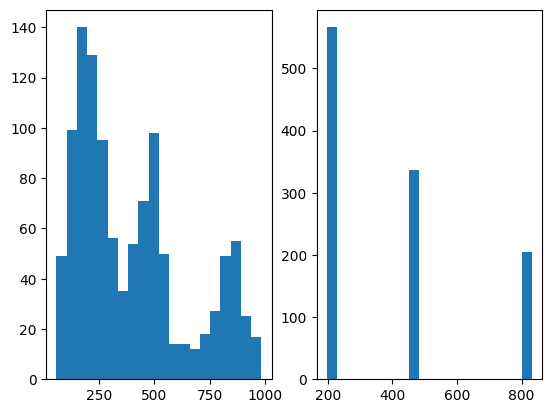

In [16]:
fig,axs = plt.subplots(1,2)
axs[0].hist(center_X, bins=20)
axs[1].hist(cluster_X,bins=20)